In [250]:
from skimage.morphology import skeletonize, thin, binary_erosion
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
import imageio
from scipy import misc
from skimage import color
from skimage import measure
import sys

#Set up workspace
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import pylab as plx

np.set_printoptions(threshold=sys.maxsize, linewidth=1000)

In [251]:
"""
Tommy's Utility Functions for converting images from color to black and white.
"""

def make_bw(img,thresh=130):
    # Converts from color to bw/binary image
    gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 
    gray_img = gray(img)
    bw_img = bw_convert(gray_img,thresh)
    
    return bw_img

def bw_convert(img,thresh):
    # Converts the grayscale to a simple black-white: that may help us in observing the 
    # "Fractal" structure (and other formal qualities)
    bw_pic = img.copy()
    bw_mask = bw_pic[:, :,] < thresh
    bw_pic[bw_mask] = 0
    bw_pic[~bw_mask] = 1
    return bw_pic


(335, 332, 3)
[ True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True  True False  True  True  True  True  True  True  True  True  

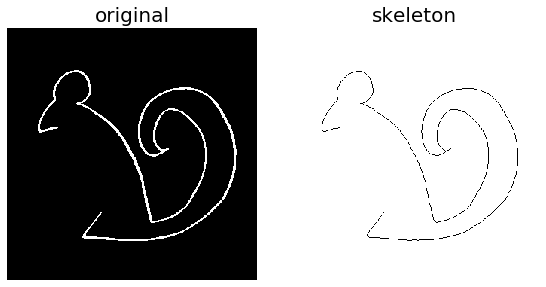

In [252]:
# Invert the squirrel image
squirrel = imageio.imread('images/squirrel.jpg') 
print(squirrel.shape)

squirrel_bw = invert(make_bw(squirrel))
skeleton = invert(thin(squirrel_bw))

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(squirrel_bw, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)
print(skeleton[150])

fig.tight_layout()
plt.show()

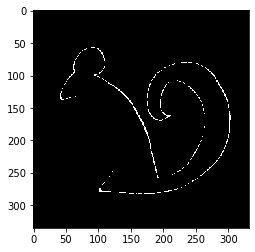

In [253]:
inverted_image = invert(make_bw(squirrel))
eroded_image = binary_erosion(inverted_image)

plt.imshow(eroded_image, cmap=plt.cm.gray)

Neither erosion nor skeleton produces a nice continuous set of points; we'll have to go another route. We ultimately landed on using contours, and grabbing the "correct" 50% constituting one line.

This is a fairly manual process that mostly comprised of "guessing and checking", and in future iterations, we'd like to find a more elegant / automated solution to this.

(1, 3177, 2)


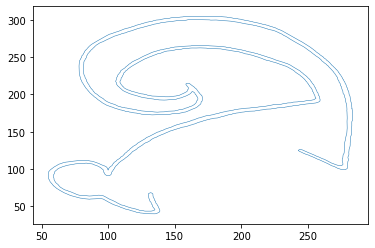

In [254]:
initial_image = imageio.imread("images/squirrel.jpg")
gray_scale_image = color.colorconv.rgb2grey(initial_image)
contours = measure.find_contours(gray_scale_image, 0.8)
# Now cast it to an NP array so it's more workable.
contours = np.array(contours)
print(contours.shape)

contour = contours[0]
xs = contour[:, 0]
ys = contour[:, 1]
plt.plot(xs, ys,  linewidth=0.5)
plt.show()


def rotate_points(coordinate_pair):
    """
    Rotates the image reverse -90 degrees.
    """ 
    rotation_matrix = np.array([
        [0, 1],
        [-1, 0]
    ])
    result = np.matmul(rotation_matrix, coordinate_pair)
    return result

def translate_y(coordinate_pair):
    # TODO: these numbers are super hard-coded --- there's probably a simple way to make
    # This more programmatic by picking the most negative Y if there are negatives and 
    # translating it; And if all Y's are positive, bring them down
    result = [coordinate_pair[0], coordinate_pair[1] + 300]
    return result

# Do a reverse 90-degree matrix transformation on the points to rotate the image
contours = np.array([[rotate_points(cp) for cp in contours[0]]])
# And now move the points upwards by adding 300 to each point 
contours = np.array([[translate_y(cp) for cp in contours[0]]])

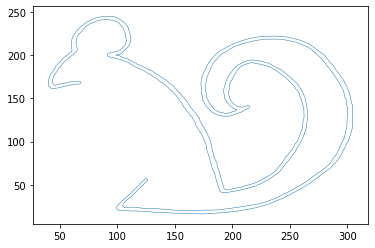

In [255]:
# Image once after the above matrix transformations have been applied:
contour = contours[0]
xs = contour[:, 0]
ys = contour[:, 1]
plt.plot(xs, ys,  linewidth=0.5)

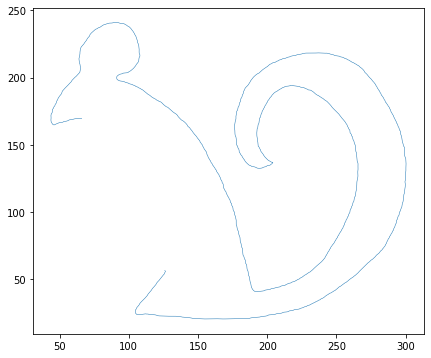

In [256]:
# Now, we must find the approximate 50% of the image to generate just one line; 
# since the vector starts and ends at the same point. This is a deeply manual process, 
# and if we had the extra time, perhaps we could find a way to automate this.
row_start = 1465
row_end = 3025

# Now, we can plot the image
# TODO: Get a figure at the normal size
plt.figure(figsize=(7, 6))

contour = contours[0]
xs = contour[row_start:row_end, 0]
ys = contour[row_start:row_end, 1]
plt.plot(xs, ys,  linewidth=0.5)


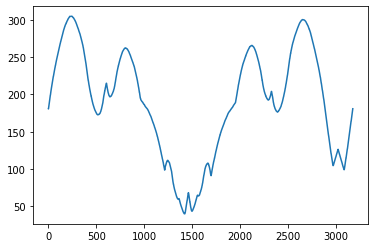

In [257]:
# To confirm that this is a continuous line that the vector gave us
plt.plot(contours[0, :, 0])
plt.show()

Text(0.5, 1.0, 'Squirrel, separated into line segments for interpolation')

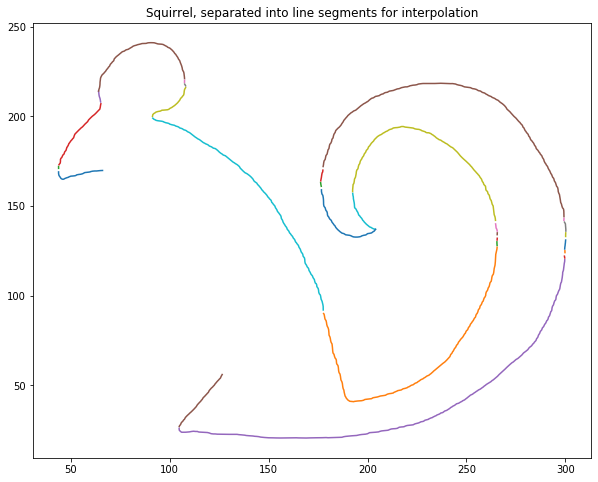

In [258]:
# Process so far: Use vectorization, grab roughly 50% of the line, since there's a start and end point
# Now that we have the continuous line traced, we'll run it through an algorithm to sectionize the line
line_contour = contours[0][row_start:row_end]

def extract_line_segments(line):
    """
    Extracts the line segments for vectorized contour lines such that there 
    are no overlapping Xs. Each of these line segments will be used for
    interpolating a spline. 
    
    Works by detecting the direction of the X, and every time it changes,
    it takes all data points starting at the last segment up until the current index
    to create a new segment, and then starts a new segment pair. 
    A positive direction is marked as True, whereas a decreasing X 
    is indicated as False.
    """
    all_segments = []

    for index, coordinate in enumerate(line):
        x, y = coordinate
        if index == 0:
            """
            Stick the initial two points into the segment array
            and get the first "prev_direction" (which will be the same 
            as the next on the initial run) to start the process.
            """
            segment_start = 0
            prev_direction = (x - line[1][0]) < 0
            previous_x = x
            continue
        direction = (x - previous_x) > 0

        if direction != prev_direction:
            all_segments.append(line[segment_start:index])
            segment_start = index
        previous_x = x
        prev_direction = direction
    return np.array(all_segments)

line_segments = extract_line_segments(line_contour)

plt.figure(figsize=(10, 8))
for line_segment in line_segments:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)

plt.title("Squirrel, separated into line segments for interpolation")

We now reduce the number of line segments for this drawing from 36 to 19 segments total


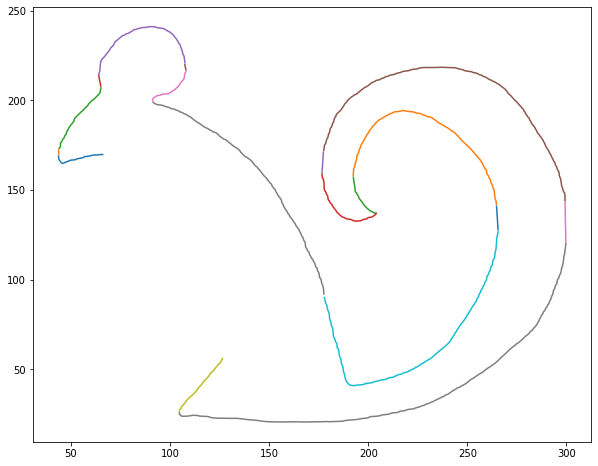

In [263]:
def handle_micro_segments(line_segments, threshold):
    """
    Detects a series of adjacent micro-segments and connects
    them into one larger segment for spline interpolation.
    
    Threshold indicates the number of points that a segment
    must fall under for it to be deemed "too small."
    """
    result = []
    aggregate_segment_indices = []
    aggregation_mode = False
    for index, segment in enumerate(line_segments):
        size = segment.shape[0]
        if size < threshold:
            if not aggregation_mode:
                aggregation_mode = True
                # Grab the first item of the small segment
                first_small_point = segment[0]
            else:
                # Keep grabbing segments
                continue
        else:
            # This means that we need to start small_segment 
            # over again because we saw a huge chunk
            # So, reset aggregation mode
            if aggregation_mode:
                # Save a bookmark to where the "aggregate" indices are
                aggregate_segment_indices.append(len(result))
                last_small_point = line_segments[index - 1][-1]
                # First small and last small should be points
                segment_of_small_points = np.array([first_small_point, last_small_point])
                result.append(segment_of_small_points)

            aggregation_mode = False
            result.append(segment)
    return (np.array(result), aggregate_segment_indices)
                

reduced_line_segments, aggregate_indices = handle_micro_segments(line_segments, 10)

# TODO: remove tiny segments, and maybe add a third point to any particularly vertical lines
# We can now also process the direction that the lines are going in, figure out the direction of the tiny segments
# And then append them to either end if possible

plt.figure(figsize=(10, 8))
for line_segment in reduced_line_segments:
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys)

print(f"We now reduce the number of line segments for this drawing from {len(line_segments)} to {len(reduced_line_segments)} segments total")

Further reduced the number of line segments from 19 to 14


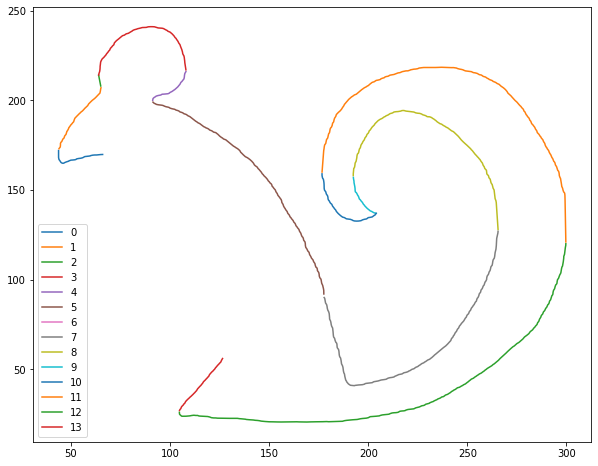

In [273]:
def attach_micro_segments_to_larger(line_segments, aggregate_segment_indices):
    """
    After running our line segments through extract_line_segments,
    our segments are guaranteed to go in one direction.
    
    We can take advantage of this property, to detect the direction
    of the mini line segments, and attach them to a neighboring larger one,
    such that we get even fewer "chunks."
    """
    result = []
    skip_next_iteration = False
    for index, line_segment in enumerate(line_segments):
        if index in aggregate_segment_indices:
            point_1, point_2 = line_segments[index]
            # Detect direction:
            direction = (point_2[0] - point_1[0]) > 0
            # Now, look at the direction of neighboring segments:
            
            # TODO: MAKE SURE THERE ARE NO LINE SEGMENTS EITHER END
            neighbor_1 = line_segments[index - 1]
            neighbor_2 = line_segments[index + 1]

            direction_neighbor_1 = (neighbor_1[1][0] - neighbor_1[0][0]) > 0
            direction_neighbor_2 = (neighbor_2[1][0] - neighbor_2[0][0]) > 0

            # Must always append the second point to the end of the first neighbor
            if direction == direction_neighbor_1:
                new_result = np.concatenate([result[-1], np.array([point_2])], axis=0)
                result[-1] = new_result

            # And the first point for the second neighbor on the right
            elif direction == direction_neighbor_2:
                new_segment = np.concatenate([np.array([point_1]), neighbor_2], axis=0)
                result.append(new_segment)
                skip_next_iteration = True
            else:
                result.append(line_segment)
        else:
            if skip_next_iteration:
                skip_next_iteration = False
            else:
                # If the segment is going in a different direction than either
                # neighbor, append it by itself.
                result.append(line_segment)
    return np.array(result)

final_segments = attach_micro_segments_to_larger(reduced_line_segments, aggregate_indices)

plt.figure(figsize=(10, 8))
for index, line_segment in enumerate(final_segments):
    xs = line_segment[:, 0]
    ys = line_segment[:, 1]
    plt.plot(xs, ys, label=index)
plt.legend()
    
    
print(f"Further reduced the number of line segments from {len(reduced_line_segments)} to {len(final_segments)}")

In [267]:
# Arg, I screwed up here somewhere. #TODO: MUST FIX
final_segments[0]

array([[204.        , 136.982385  ],
       [203.37294574, 136.        ],
       [203.        , 135.80631547],
       [202.027046  , 135.        ],
       [202.        , 134.97706097],
       [201.        , 134.73595823],
       [200.        , 134.57833922],
       [199.32721831, 134.        ],
       [199.        , 133.82108988],
       [198.        , 133.63695798],
       [197.        , 133.29764576],
       [196.61921636, 133.        ],
       [196.        , 132.81191131],
       [195.        , 132.67337089],
       [194.        , 132.646973  ],
       [193.        , 132.72629259],
       [192.18867414, 133.        ],
       [192.        , 133.19198421],
       [191.        , 133.62184679],
       [190.        , 133.76627267],
       [189.        , 133.91644873],
       [188.82398533, 134.        ],
       [188.        , 134.58380268],
       [187.        , 134.88224911],
       [186.87728849, 135.        ],
       [186.        , 135.7215568 ],
       [185.72641337, 136.        ],
 

dict_values([array([46.        , 43.77048571])])
dict_values([array([228., 230., 237., 242., 243.])])
dict_values([array([181., 179., 169., 167., 166., 164., 160., 159., 156., 155.]), array([134., 132., 131., 130., 127., 126.]), array([112., 108., 107., 106.])])
Line segments and local extrema


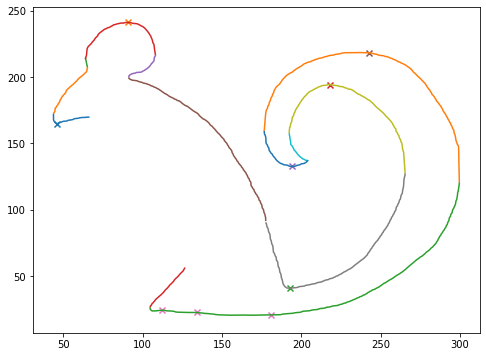

In [466]:
from scipy.signal import argrelextrema

def cut_indices(numbers, tolerance):
    # this function iterate over the indices that need to be 'cut'
    for i in range(len(numbers)-1):
        if math.fabs(numbers[i+1] - numbers[i]) > tolerance:
            yield i+1

def splitter(numbers, tolerance):
    # this function split the original list into sublists.
    px = 0
    for x in cut_indices(numbers, tolerance):
        yield numbers[px:x]
        px = x
    yield numbers[px:]

def cluster(numbers, tolerance):
    # using the above result, to form a dict object.
    cluster_ids = range(1,len(numbers))
    return dict(zip(cluster_ids, splitter(numbers, tolerance)))

def find_extrema(line_segments, tolerance=10):
    """
    Find the indices of all local minima and maxima of a series of points,
    which we'll use as the starting points for the interpolation.
    
    Sometimes there will be multiple local minima and maxima clustered together
    due to the stochastic nature of a pencil stroke. The tolerance parameter checks 
    for any points that are within a certain distance of one another in terms of indices, 
    and returns the max of the sets.
    
    Returns a tuple of the line segment itself, alongside the indices of where
    the extrema lie.
    """
    results = []
    for line_segment in line_segments:
        local_maxima = argrelextrema(line_segment, np.greater)[0]
        local_minima = argrelextrema(line_segment, np.less)[0]
        extrema_indices = np.concatenate([local_maxima, local_minima])
        extrema_indices.sort()
        
        if len(extrema_indices) > 1:
            # We can further smooth out the local maxima and minima by looking through the array--if there are too many
            # indices "clustered together, figure out where that is happening and pick the result"
            # If there are a lot of local minima and maxima clustered together 
            x_values = line_segment[extrema_indices][:, 0]
            # OOPS: These are not the indices of the original line segments
            clusters = cluster(x_values, tolerance)

            extrema_indices = []
            print(clusters.values())
            for c in clusters.values():
                # For each cluster, just pick one point
                # I just picked the max for now. 
                # TODO: REVIIST THIS, MAYBE SEPARATE IT OUT FOR MAXES AND MINS?
                extrema_indices.append(np.array(c).max())
            extrema_indices = [np.where(line_segment[:, 0] == e)[0][0] for e in extrema_indices]        
        results.append((line_segment, extrema_indices))

    return np.array(results)

plt.figure(figsize=(8, 6))

segments_with_extrema = find_extrema(final_segments)
for segment, extrema_indices in segments_with_extrema:
    xs = segment[:, 0]
    ys = segment[:, 1]
    plt.plot(xs, ys)
    if len(extrema_indices) > 0:
        extrema_xs = segment[extrema_indices][:, 0]
        extrema_ys = segment[extrema_indices][:, 1]
        plt.scatter(extrema_xs, extrema_ys, marker="x")
        
print("Line segments and local extrema")

In [386]:
for 

SyntaxError: invalid syntax (<ipython-input-386-eaf083cb72bb>, line 1)

Aside from documentation of the tools used (see imports above), here are some resources
I used as reference:

- http://freeconnection.blogspot.com/2013/07/vectorize-image-with-python-scikit-image.html

In [ ]:
## SCRAP
        differences = np.where(np.abs(np.diff(x_values)) > tolerance)
#         print(differences)
#         print("The differences", differences)
#         if differences > tolerance:
        # The below line of code is adapted from:
        print(np.where(np.diff(x_values) > tolerance))
#         import sys; sys.exit()
        # https://stackoverflow.com/questions/15800895/finding-clusters-of-numbers-in-a-list
#         nd = list(np.where(np.diff(extrema) > tolerance)[0] + 1) + [len(extrema)]
#         print(nd)